# Problem 1, classification of hand written digits

## Introduction
The dataset for this problem has been downloaded "keras.datasets" and containt 70,000 pictures. 60,000 are used to train and validate the model and 10,000 are used to test the model.

This is a multi-class classification problem where there are 10 classes, i.e. digits from 0 to 9. There are several algorithms for solving this problem and convolutional neural network is the chosen method.

This python notebook is run on Google Colab.
The code works as follow:


1.   **SECTION: Preparing the dataset**. Download the dataset and prepare the dataset. Actions include:

*   Import all the libraries useful for this code to work
*   Download the dataset from keras.dataset
*   Split the data into training, validation and testing set 
*   Scale the pictures since neural networks work better with smaller inputs
*   Convert the class labels into One-Hot Encoding to feed them to Tensor flow
*   Visualize some of the training samples
*   Image augmentation, a form of regularization, is used to increase the training size and avoiding overfitting. In this case, the new images are generated by either zooming, rotating, or shifting. A sample of the augmented images are visualized



2.   **SECTION: Definition of the CNN**.

The architecture used is a neural network composed of convolutional layers and fully connected layer. There are 7 convolutional layers and 1 fully connected layer. The architecture has been chosen takes inspiration from the architecture of Chris Deotte with some modification decided doing some experiments on the optimality of the parameter chosen. Moreover, one of the criteria for choosing the architecture was training time. In fact, the choice for this work is to prefer a slighlty less accurate CNN that can be trained faster and can compute the results faster. The architecture has 290,922 and 290,282 of these parameters are trainable.  
The architecture can be described as follows:

*  **Convolutional Layer 1**: convolutional layer with 32 filters and a kernel size 3X3. For this layer bias is used. Moreover a valid padding with a stride of 1 is used. Finally, the activation function used in this layer is Relu. 
* Batch normalization is applied to speed up training and add a bit of regularization. 
* **Convolutional Layer 2**: convolutional layer with 32 filters and a kernel size 5X5. For this layer bias is used. Moreover same padding with a stride of 2 is used. Finally, the activation function used in this layer is Relu. 
* Batch normalization is applied. 
* 0.4 dropout (dropping out units in a neural network) is applied. Again, this helps preventing overfitting by adding another form of regularization.
*  **Convolutional Layer 3**: convolutional layer with 64 filters and a kernel size 3X3. For this layer bias is used. Moreover a valid padding with a stride of 1 is used. Finally, the activation function used in this layer is Relu. 
* Batch normalization is applied. 
* **Convolutional Layer 4**: convolutional layer with 64 filters and a kernel size 5X5. For this layer bias is used. Moreover same padding with a stride of 2 is used. Finally, the activation function used in this layer is Relu. 
* Batch normalization is applied. 
* 0.4 dropout is applied.    
*  **Convolutional Layer 5**: convolutional layer with 128 filters and a kernel size 4X4. For this layer bias is used. Moreover a valid padding with a stride of 1 is used. Finally, the activation function used in this layer is Relu. 
* Batch normalization is applied. 
*  Input from the previous convolutional layer is flattened to create a fully connected layer with 1152 units.
* 0.3 dropout is applied.  
*  **Output later**: This is the output layer with 10 units, bias is used and the softmax activation function is applied in order to get as final output probabilities for each of the 10 classes.

3.   **SECTION: Defining Training function**.

In this section, the function for training the CNN is defined. For the training, the inputs are the number of epochs for training, batch size. The algorithm used for the training the Adam algorithm. Adam is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. The loss function chosen is categorical crossentropy which computes the cross-entropy loss between true labels and predicted labels. Labels have to be provided in a one_hot representation. The loss function is defined as 
$L(\hat y,y) = \ sum_{j=0}^{M} \sum_{i=0}^{N} \left( y_{ij} log(\hat y_{ij}) \right) $  
where $\hat y$ is the predicted label, $N$ is the number of batch samples and $M$ is the number of classes.

The number of epochs chosen for training is 45 using 32 as batch size.
In the training function, it is chosen to use early stop criterion to avoid overfitting. If the validation loss does not decrease for a specified number of epochs then the training stops. Moreover, the learning rate is variables during the training. Finally, it is chosen to use checkpoints during the training the saving the model with the lowest validation loss obtained. The metric is a function that is used to judge the performance of your model. The metric used here is accuracy which calculates how often predictions equals the true labels. The reason of choosing this metric is that roughly each class has a similar quantities of samples. If class imbalance is present (one class more samples than others or vice versa) then it is better using other metrics such as precision and recall or F1 score. 

At the end of training, also the training and validation accuracy and loss are plotted.

4.   **SECTION: Defining Test function**.

In this section the function to test the model trained is defined. This function computes the predictions given a set of input images. 

5.   **SECTION: Defining functions to evaluate the model**.

In this section various functions are defined. 

* function to plot loss and accuracy for training and validation set,
* function to compute accuracy, precision, recall and F1 score for the test set to evaluate the trained model.  
* function to display the classification report for the test test (number of samples in each class, various metrics computed for each class, etc.)
* function to plot some random samples of the test test and visualize the image, the correct label, the predicted label and the level of condifence of the model

The metric chosen here is precision although also the other metrics are computed and displayed. 

6.   **SECTION: Training and testing the model**.

In this section, the model is trained, is tested on the test and then evaluated using the various metrics. The final metric used for evaluating the model is accuracy which calculates how often predictions equals the true labels. We can see that the model accuracy on the test set (unseen data) is $ \approx 99.65\%$
In this section some the predicted and actual labels together with the image can be seen.


Thanks,
Gabriele Boncoraglio


In [1]:
'''
  Some import statement useful for later code
'''

from keras.models import Model
import keras.layers
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import  img_to_array, array_to_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D,BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler

import tensorflow as tf
import tensorflow.keras.layers as ll
from skimage.transform import resize
import scipy as sp
import numpy as np
import pandas as pd
import PIL
import scipy.ndimage as spi
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# if MODEL_TRAINED == True, then it load a computed model already trained
MODEL_TRAINED = False
BATCH_SIZE = 32

# sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()

Using TensorFlow backend.


# Preparing the dataset
Creating training, validation and test sets and editing the data to improve the training accuracy.

In [2]:
'''
  Visualizing the size of the dataset
'''
(train_img, train_labels), (x_test, test_labels) = mnist.load_data()
print("Number of training images for training: {}".format(train_labels.shape[0]))
print("Number of validation images for testing: {}".format(test_labels.shape[0]))
print("")
print("Resolution image: {} x {}".format(train_img.shape[1],train_img.shape[2]))
print("")
print("")

'''
prepare our train, test and validation datasets
'''

x_train, x_valid, y_train, y_valid = train_test_split(train_img, train_labels, 
                                                    test_size=0.166666666, 
                                                    stratify=np.array(train_labels), 
                                                    random_state=1234)

print('Initial Training Dataset Size:', x_train.shape[0])
print('Initial Validation Datasets Size:', x_valid.shape[0])
print('Initial Test Datasets Size', x_test.shape[0])
print("")
print("")



def convert4D(X,convertRGB=True):
  # Set reshaped array to X 
  X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

  return X

def convertRGB(X):
    # Convert images and store them in X3
    X3 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X),name=None)
    return X3

x_train = convert4D(x_train)
x_valid = convert4D(x_valid)
x_test = convert4D(x_test)

x_train1 = convertRGB(x_train)
x_valid1 = convertRGB(x_valid)
x_test1 = convertRGB(x_test)
                           
x_train = x_train.astype('float32')
x_valid  = x_valid.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

x_train1 /= 255
x_valid1 /= 255
x_test1 /= 255



'''
  convert the text class labels to one-hot encoded labels
'''
y_train_ohe = pd.get_dummies(y_train).to_numpy()
y_val_ohe = pd.get_dummies(y_valid).to_numpy()
y_test_ohe = pd.get_dummies(test_labels).to_numpy() 

print("Shape of training input is: ",x_train.shape)
print("Shape of training output is: ",y_train_ohe.shape)

Number of training images for training: 60000
Number of validation images for testing: 10000

Resolution image: 28 x 28


Initial Training Dataset Size: 50000
Initial Validation Datasets Size: 10000
Initial Test Datasets Size 10000


Shape of training input is:  (50000, 28, 28, 1)
Shape of training output is:  (50000, 10)


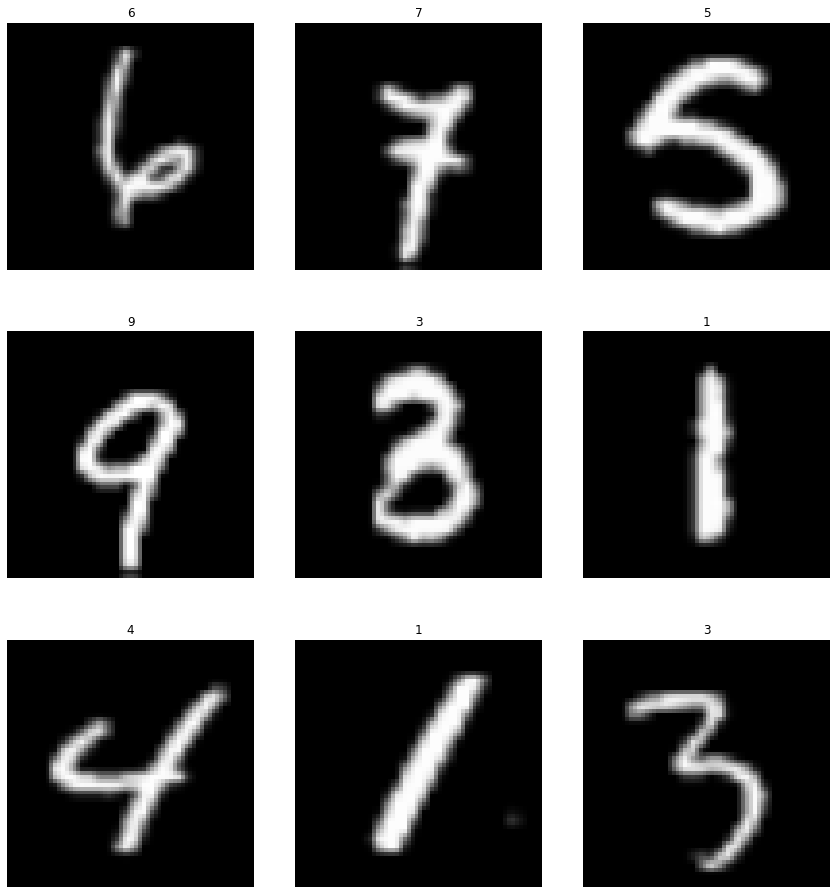

In [3]:
''' 
    Visualzing the dataset
'''
    
# This function plots sample images in specified size and in defined grid
def plot_batch(images_df,labels_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(12, 12)
    
    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            ax[i][j].set_title(str(labels_df[img_idx]))
            ax[i][j].imshow(resize(images_df[img_idx],(im_scale_x,im_scale_y)))
            img_idx += 1
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

n_rows = 3
n_cols = 3
plot_batch(x_train1[:(n_rows*n_cols)],y_train[:(n_rows*n_cols)], grid_width=n_rows, grid_height=n_cols,
           im_scale_x=64, im_scale_y=64)

Image augmentation is helpful for regularization (i.e. avoiding overfitting). Therefore, while training we create additional images using rotation, rotation and shift. This allows also to increase the size of the training data. In the following part of code, we plot some of the pictures that could be generated during training using image augmentation.

Labels: [6, 6, 6, 6, 6]


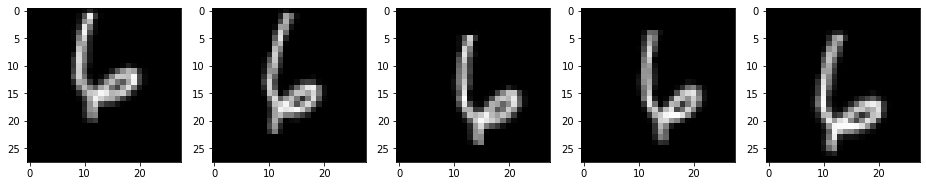

In [4]:
'''
    Let’s see how some of these generated images might look using image augmentation
'''

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1, 
                                   rotation_range=10, 
                                      zoom_range = 0.10,  
                                      width_shift_range=0.1, 
                                      height_shift_range=0.1)
                                  #  vertical_flip = 'true')
train_generator = train_datagen.flow(x_train1, y_train_ohe, shuffle=False, 
                                     batch_size=32, seed=1)

img_id = 0
num_generator = train_datagen.flow(x_train1[img_id:img_id+1], y_train[img_id:img_id+1],
                                   batch_size=1)
num = [next(num_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in num])
l = [ax[i].imshow(num[i][0][0]) for i in range(0,5)]


# Definition of the CNN

This model is composed of 159,830 parameters to be trained.
The first part is composed of convolutional layers and then there are fully connected layers.

In [0]:
'''
  Defining weights and bias
'''

def defineModel(input_shap = (28, 28, 1),total_classes = 10):
    """Given the input size and output size, it return a CNN model built in TensorFlow

    Keyword arguments:
    input_shap -- shape of the input 
    total_classes -- number of classes for the multiclassification problem (minimum 2) 
    
    Return Tensor flow CNN
    """


    model = Sequential()
    #convolutional layers
    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape=input_shap ))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    #fully connected layers layers
    model.add(Flatten())

    model.add(Dropout(0.3))
    model.add(Dense(total_classes, activation='softmax'))

    model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
    return model

# Defining Training function

In [0]:
'''
  Defining training function
'''

def train(model,x_train,x_valid,y_train_ohe,y_val_ohe,batch_size= 32,
          n_epochs=100,epochs_to_wait_for_improve = 40, model_name = 'mnist_simple_cnn'):
    '''
      This function save both the model with the lowest validation loss
      and the model at the last epoch

      Inputs
      

      Outputs
      history: history of the training 
    '''

    """Given the CNN model built in TensorFlow, it trained using the training set 
       and use the validation set as validation.

    Keyword arguments:
    model --  Tensor flow model to train
    x_train -- training data input
    x_valid -- validation data input
    y_train_ohe -- training data output (1 hot encoder)
    y_val_ohe -- validation data output (1 hot encoder)
    batch_size -- batch_size for training 
    n_epochs -- number of epochs for training
    epochs_to_wait_for_improve -- epochs after which if the model does not improve,
                                  the training stop
    model_name -- filename for saving the trained model
    
    Return history of loss and accuracy computed during training 
    """


    # Create train generator.
    train_datagen = ImageDataGenerator(rescale=1, 
                                      rotation_range=10, 
                                      zoom_range = 0.10,  
                                      width_shift_range=0.1, 
                                      height_shift_range=0.1)
                                      #  vertical_flip = 'true')
    train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, 
                                        batch_size=BATCH_SIZE, seed=1)
    
    # Create validation generator
    val_datagen = ImageDataGenerator(rescale = 1.)
    val_generator = train_datagen.flow(x_valid, y_val_ohe, shuffle=False, 
                                      batch_size=BATCH_SIZE, seed=1) 

    train_steps_per_epoch = x_train.shape[0] // batch_size
    val_steps_per_epoch = x_valid.shape[0] // batch_size

     
    early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epochs_to_wait_for_improve)
    #Saving the model with the lowest val loss
    checkpoint_callback = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+n_epochs))
    history = model.fit_generator(train_generator,
                                  steps_per_epoch=train_steps_per_epoch,
                                  validation_data=val_generator,
                                  validation_steps=val_steps_per_epoch,
                                  epochs=n_epochs, verbose=1,
                                  callbacks=[early_stopping_callback, checkpoint_callback,annealer])

    return history


# Defining Test function


In [0]:
'''
  Defining test function
'''

def testModel(model,x_test):
    """Given the trained CNN model built in TensorFlow and a test set, it computed the predictions

    Keyword arguments:
    model -- tensorflow model trained
    x_test -- input to test
    
    Return:
    predictions -- a list with the predicted classes for each sample
    predictions_acc -- a list of probabilities for the predicted classes for each sample
    """

    # Create test generator
    test_datagen = ImageDataGenerator(rescale = 1.)
    val_generator = test_datagen.flow(x_test, None, shuffle=False, 
                                      batch_size=BATCH_SIZE, seed=1) 
    # Compute the predictions
    test_predictions = model.predict_generator(val_generator,verbose=0)
    predictions_acc = list(np.max(test_predictions, axis=1))
    predictions = list(np.argmax(test_predictions, axis=1))
    return predictions,predictions_acc

# Defining functions to evaluate the model

Since the classes are balanced, I am using accuracy defined as 
 accuracy = (# total correct samples guessed) / (# total test samples)

In [0]:
''' 
  Plotting the CNN training history 
'''
def plotHistory(history):
  """Given the history of training it plots loss and accuracy metric

    Keyword arguments:
    history -- history output from training
    
    Return: None
    """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle('Basic CNN Performance', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  n_epochs =  len(history.history['accuracy'])
  epoch_list = list(range(1,n_epochs+1))
  ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
  ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_xticks(np.arange(0, n_epochs+1, 5))
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')
  l1 = ax1.legend(loc="best")

  ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
  ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
  ax2.set_xticks(np.arange(0, n_epochs+1, 5))
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  l2 = ax2.legend(loc="best")


'''
  Computing and printing various metrics 
'''
def get_metrics(true_labels, predicted_labels):
    """Computes various metrics and then it prints them on the screen and also return them

    Keyword arguments:
    true_labels -- true labels for test data
    predicted_labels -- predicted labels for test data
    
    Return: 
    acc -- Accuracy computed
    prec -- Precision computed
    rec -- Recall computed
    F1 -- F1 Score computed
    """
    acc = np.round(metrics.accuracy_score(true_labels,predicted_labels),4)
    prec = np.round(metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),4)
    rec = np.round(metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),4)
    F1 = np.round(metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),4)
    print('Accuracy:',acc )
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', F1)
    return (acc,prec,rec,F1)

'''
  Printing report for the multiclass problem
'''
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):
    """Computes report for the classification problem
       How many samples in each class, and for each class computes various metrics

    Keyword arguments:
    true_labels -- true labels for test data
    predicted_labels -- predicted labels for test data
    classes -- name of the classes for the classification problem
    
    Return: 
    report -- table with various metrics computed for each class
    """

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)
    return report



'''
  visualize model predictions in a visually appealing way
'''
def visualizePrediction(test_set_input,test_labels,predictions,predictions_acc):
    """Visualize sample images from the test set and show the actual label, predicted labels,
       and level of confidence of the model.

    Keyword arguments:
    test_set_input -- input images of the test set
    test_labels -- actual labels of test set 
    predictions -- predicted labels for test set
    predictions_acc -- probability for each prediction made by the model
    
    Return: None
    """

    grid_width = 3
    grid_height = 3
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(15, 15)
    batch_size = 25
    

    labels_ohe_names = pd.get_dummies(test_labels, sparse=True)
    labels_ohe = np.asarray(labels_ohe_names)
    label_dict = dict(enumerate(labels_ohe_names.columns.values))
    model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
    random_batch_indx = np.random.permutation(np.arange(0,len(test_set_input)))[:batch_size]

    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            actual_label = str(np.array(test_labels)[random_batch_indx[img_idx]])
            predicted_label = str(predictions[random_batch_indx[img_idx]])
            conf = str(round(predictions_acc[random_batch_indx[img_idx]], 3))
            ax[i][j].axis('off')
            ax[i][j].set_title('Actual: '+actual_label+'\nPredicted: '+predicted_label + '\nConfidence: ' + conf)
            ax[i][j].imshow(test_set_input[random_batch_indx[img_idx]])
            img_idx += 1

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    

# Running the entire code

In [9]:
# Create the model
model = defineModel(input_shap = (28, 28, 1),total_classes = 10)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 64)       

Epoch 1/45
1562/1562 [==============================] - 46s 29ms/step - loss: 0.9034 - accuracy: 0.7142 - val_loss: 0.1183 - val_accuracy: 0.9344

Epoch 00001: val_loss improved from inf to 0.11829, saving model to mnist_simple_cnn.h5
Epoch 2/45
1562/1562 [==============================] - 39s 25ms/step - loss: 0.2455 - accuracy: 0.9224 - val_loss: 0.3102 - val_accuracy: 0.9654

Epoch 00002: val_loss did not improve from 0.11829
Epoch 3/45
1562/1562 [==============================] - 40s 25ms/step - loss: 0.1643 - accuracy: 0.9491 - val_loss: 0.0430 - val_accuracy: 0.9745

Epoch 00003: val_loss improved from 0.11829 to 0.04304, saving model to mnist_simple_cnn.h5
Epoch 4/45
1562/1562 [==============================] - 39s 25ms/step - loss: 0.1297 - accuracy: 0.9601 - val_loss: 0.0022 - val_accuracy: 0.9789

Epoch 00004: val_loss improved from 0.04304 to 0.00216, saving model to mnist_simple_cnn.h5
Epoch 5/45
1562/1562 [==============================] - 40s 25ms/step - loss: 0.1069 - ac

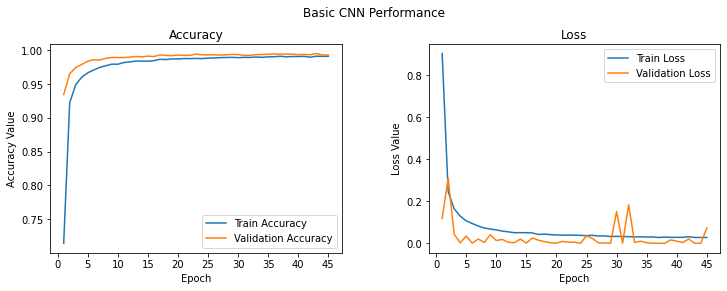

In [10]:
if not MODEL_TRAINED:
    N_EPOCHS = 45
    history  = train(model,x_train,x_valid,y_train_ohe,y_val_ohe,batch_size= BATCH_SIZE,
            n_epochs=N_EPOCHS,epochs_to_wait_for_improve = 40, model_name = 'mnist_simple_cnn')
    # Plotting the history of training
    plotHistory(history)


In [11]:
# Load the trained model
tl_img_aug_cnn = load_model('mnist_simple_cnn.h5')
# Get prediction for the test_data
(predictions,predictions_acc) = testModel(tl_img_aug_cnn,x_test)

# evaluate model performance
(acc,prec,rec,F1) = get_metrics(true_labels=test_labels, predicted_labels=predictions)

Accuracy: 0.9965
Precision: 0.9965
Recall: 0.9965
F1 Score: 0.9965


In [12]:
# Get a report of the test data evaluation
labels_ohe_names = pd.get_dummies(test_labels, sparse=True)
report = display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



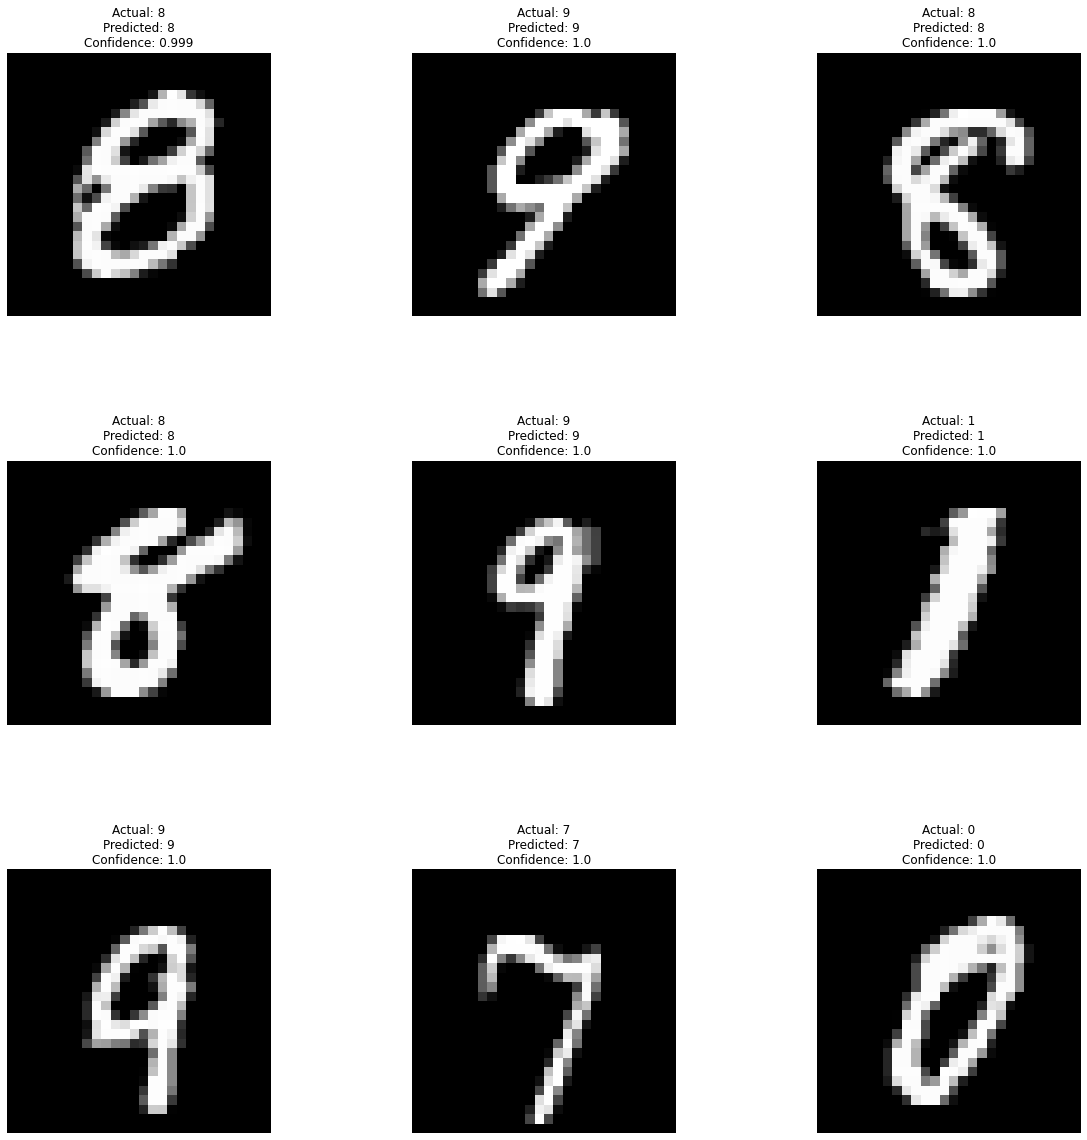

In [18]:
# visualize model predictions in a visually appealing way
visualizePrediction(x_test1,test_labels,predictions,predictions_acc)

In [0]:
sess.close()